# Step 4: Data Exploration

This notebook peforms exploratory anlaysis on the enriched artist trend dataset. The goal is to understand the structure, quality, and content of the data before modeling and transforming.

Outline
- Loading Data and Preview
- Descriptive Data
- Cleaning


## Initial Data Preview

When running pd.read_csv(), there was a warning regarding the 'id' column. To avoid the 'Data Type Warning: Mixed Types', data types were explicitly for all columns.

Additionally, the genre column has multiple genres separated by semi-colons (;). This will need to be cleaned up after the exploratory portion of this notebook.

In [2]:
"""Load Data and Preview"""

import pandas as pd 
from pathlib import Path

batch_date = "2025_06_18"
file = f"spotify_rising_with_trends_{batch_date}"
input_path = Path(f"../data/stage2_trend_enrichment/{file}.csv") #Verify this is the most up to date path

#Column 'id' has a Data Type Warning: Mixed Types. The following specifies the data type to avoid this warning
df = pd.read_csv(
    input_path,
    parse_dates=["date"],
    dtype={
        "artist": str,
        "id": str,
        "genres": str,
        "location": str,
        "trend_score": float
    }
)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (18486055, 6)


,artist,id,genres,location,date,trend_score
0,999999999,6uD2LjPHUjxrpax0se17Nc,acid techno; hard techno; techno; tekno,AK,2018-06-01,75.0
1,999999999,6uD2LjPHUjxrpax0se17Nc,acid techno; hard techno; techno; tekno,AK,2018-06-02,19.0
2,999999999,6uD2LjPHUjxrpax0se17Nc,acid techno; hard techno; techno; tekno,AK,2018-06-03,42.0
3,999999999,6uD2LjPHUjxrpax0se17Nc,acid techno; hard techno; techno; tekno,AK,2018-06-04,25.0
4,999999999,6uD2LjPHUjxrpax0se17Nc,acid techno; hard techno; techno; tekno,AK,2018-06-05,81.0


## Descriptive Data

The output below shows the genres field has a lot of null values, followed by the trend_score. These 2 fields will be significant for analyst to use downstream, so instead of removing these null rencords they will be transformed.

Trend Score Null values will be replaced with 0.
Genre Null values will be replaced with 'Unknown'.


In [3]:
"""Descriptive Data"""

df.info()
df.describe(include='all')
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18486055 entries, 0 to 18486054
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   artist       object        
 1   id           object        
 2   genres       object        
 3   location     object        
 4   date         datetime64[ns]
 5   trend_score  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 846.2+ MB


artist               0
id                   0
genres         2674265
location             0
date                 0
trend_score       2250
dtype: int64

### Descriptive Data (Continued...)

This histogram below shows the distribution of `trend_score` values across the raw dataset, before any cleaning or transformation has been applied.

### Observations:
- Most trend scores fall within the 0-100 range, as expected.
- There are a few outlier values above 100 (e.g., up to ~350), which are likely anomalies.
- The data is right-skewed, with a heavy concentration of lower trend scores.

We will validate and potentially cap these outliers in the cleaning phase to ensure scores are within an expected 0–100 range.




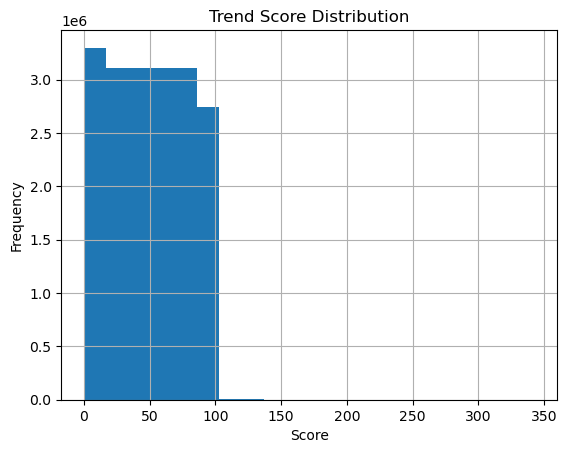

In [4]:
import matplotlib.pyplot as plt

df['trend_score'].hist(bins=20)
plt.title("Trend Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


### Descriptive Data (Continued...)

### Column Homogeneity

Before cleaning, we assess whether each column in the raw dataset contains consistent (homogeneous) data types and structures.

Checks Performed:
- `id` column: Verified that all values are of consistent length (expected: Spotify-style unique IDs).
- `location` column: Checked for consistent 2-character region codes (e.g., US state abbreviations).
- `genres` column: Evaluated whether each value is a valid string and whether any values are missing.

### Observations:
- The `id` and `location` columns appear consistent and well-formatted across all records.
- The `genres` column has 2,674,265 missing values (~14.5% of the dataset), while 15,811,790 records contain valid genre information.

This confirms that `genres` will require attention during the cleaning and normalization phase, but the data is otherwise structurally sound and ready to be transformed.


In [5]:
""" Homogeneity Check"""

df['id'].apply(len).value_counts()
df['location'].value_counts()
df['genres'].apply(lambda x: isinstance(x, str)).value_counts()
df_with_genres = df[df['genres'].notna()]
df_missing_genres = df[df['genres'].isna()]

print(f"Rows with genres: {len(df_with_genres):,}")
print(f"Rows missing genres: {len(df_missing_genres):,}")



Rows with genres: 15,811,790
Rows missing genres: 2,674,265


## Cleaning

### Step 1: Fill Missing `trend_score` Values with 0

Rather than dropping records where `trend_score` is null, we assume that a missing score represents no measurable trend on that day. We replace these with `0` to preserve date continuity for time series analysis.

This ensures we don't lose temporal granularity when aggregating or visualizing artist or genre trends.



In [6]:
""" Cleaning """

#Replace null trend scores with 0

df['trend_score'] = df['trend_score'].fillna(0)




### Cleaning (Continued...)

### Step 2: Strip Whitespace
To prevent issues during joins and grouping, we remove leading/trailing whitespace from all string columns.

In [7]:
#Trim whitespace from all string columns

string_columns = ["artist", "id", "genres", "location"]
df[string_columns] = df[string_columns].apply(lambda col: col.str.strip())


### Cleaning (Continued...)

### Step 3: Validate Score Range
We enforce a logical constraint that `trend_score` must be between 0 and 100.



In [8]:
#Filters the dataframe to include only the rows where the trend_score is 0 - 100.
df = df[df['trend_score'].between(0, 100)]


### Cleaning (Continued...)

### Step 4: Drop Rows Missing Key Identifiers

We dropped rows that are missing critical identifiers (`id`, `location`, or `date`). These fields are required for reliable joins and time-series analysis. Logging the count of dropped rows helps track how much data is excluded at this stage.

In [9]:
#Inspects the first few bad rows before dropping

df[df[['id', 'location', 'date']].isna().any(axis=1)].head()


,artist,id,genres,location,date,trend_score


In [10]:
before = len(df)

# Drop rows with missing critical fields
df = df.dropna(subset=["id", "location", "date"])

after = len(df)
dropped = before - after

print(f"Rows dropped: {dropped:,}")
print(f"Remaining rows: {after:,}")


Rows dropped: 0
Remaining rows: 18,476,926


### Cleaning (Continued...)

### Step 5: Normalize `genres` for Star Schema Modeling

Instead of dropping rows with missing genre data, we replace nulls with `"Unknown"` to retain all records. Then, we split the semicolon-delimited genre string into a list, explode it so each row has a single genre, and clean the text (strip whitespace and standardize casing).

This prepares the `genres` column for normalization into a `dim_genres` table and ensures our star schema meets 3NF.


After replacing missing genres with `'Unknown'` and exploding the genre list, we found that 6.28% of rows were transformed. This confirms a manageable level of genre incompleteness, which we can track separately in downstream reporting.


In [11]:
# Step 5: Normalize genres
# Fill missing genres with 'Unknown'
df['genres'] = df['genres'].fillna('Unknown')

# Split genres on semicolon
df['genres'] = df['genres'].str.split(';')

# Explode so each row has exactly one genre
df = df.explode('genres')

# Strip whitespace and lowercase for consistency
df['genres'] = df['genres'].str.strip().str.lower()

# Count how many rows have 'unknown' as genre after normalization
unknown_count = (df['genres'] == 'unknown').sum()
total_rows = len(df)
percent_unknown = (unknown_count / total_rows) * 100

print(f"Rows with genre = 'unknown': {unknown_count:,} ({percent_unknown:.2f}%) of {total_rows:,} total rows")



Rows with genre = 'unknown': 2,673,128 (6.28%) of 42,564,439 total rows


### Cleaning (Continued...)

### Step 6: Deduplicate Records

We dropped duplicate rows based on a combination of artist ID, genre, location, and date. This ensures that each row in the fact table represents a unique observation.

This step reduces redundancy and prepares the dataset for insertion into a fact table with consistent primary keys.


In [12]:
# Step 6: Drop duplicate records
before_dedup = len(df)

# Deduplicate based on key identifiers (artist, genre, location, date)
df = df.drop_duplicates(subset=["id", "genres", "location", "date"])

after_dedup = len(df)
deduped_count = before_dedup - after_dedup
deduped_percent = (deduped_count / before_dedup) * 100

print(f"Deduplicated {deduped_count:,} rows ({deduped_percent:.2f}%)")
print(f"Remaining rows: {after_dedup:,}")


Deduplicated 0 rows (0.00%)
Remaining rows: 42,564,439
